In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('ticks')
import numpy as np
import juliet

!pip install brokenaxes
import matplotlib as mpl
from brokenaxes import brokenaxes
mpl.rcParams['figure.dpi']= 200

/Users/nespinoza/opt/anaconda3/envs/newen/lib/python3.7/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## Loading the dataset

In [2]:
dataset = juliet.load(input_folder = 'full_circular') 
results = dataset.fit(use_dynesty=True, dynamic=True)

Detected dynamic_dynesty sampler output files --- extracting from full_circular/_dynesty_DNS_posteriors.pkl


## Let's plot the RVs

Let's plot the dataset; note we fitted the VIS RV's only first as the NIR ones are significantly noisier. We also did a joint fit with the NIR data, and the results are consistent with each other.

In [121]:
all_times = np.append(dataset.times_rv['Subaru'], dataset.times_rv['PFS'])
min_t = np.min(all_times)
max_t = np.max(all_times)
tstart = int(min_t - 5)
tend = max_t + 5
#t,rv,rverr = np.loadtxt('fullfit_2p_sd/rvs.dat',unpack=True,usecols=(0,1,2))

In [122]:
# Create model times:
tmodel = np.linspace(tstart, tend,1000)

In [123]:
# Evaluate model in them; get 68 credibility:
model, error68_up, error68_down = results.rv.evaluate('Subaru', t = tmodel, return_err = True)
# Same for 95 cred:
model, error95_up, error95_down = results.rv.evaluate('Subaru', t = tmodel, return_err = True, alpha = 0.95)
# Same, 99:
model, error99_up, error99_down = results.rv.evaluate('Subaru', t = tmodel, return_err = True, alpha = 0.99)
# Substract mu:
mu_subaru, mu_pfs = np.median(results.posteriors['posterior_samples']['mu_Subaru']),\
                    np.median(results.posteriors['posterior_samples']['mu_PFS'])

model, error68_up, error68_down, error95_up, error95_down, error99_up, error99_down = \
     model -mu_subaru, error68_up-mu_subaru, error68_down-mu_subaru, error95_up-mu_subaru, error95_down-mu_subaru, error99_up-mu_subaru, error99_down -mu_subaru

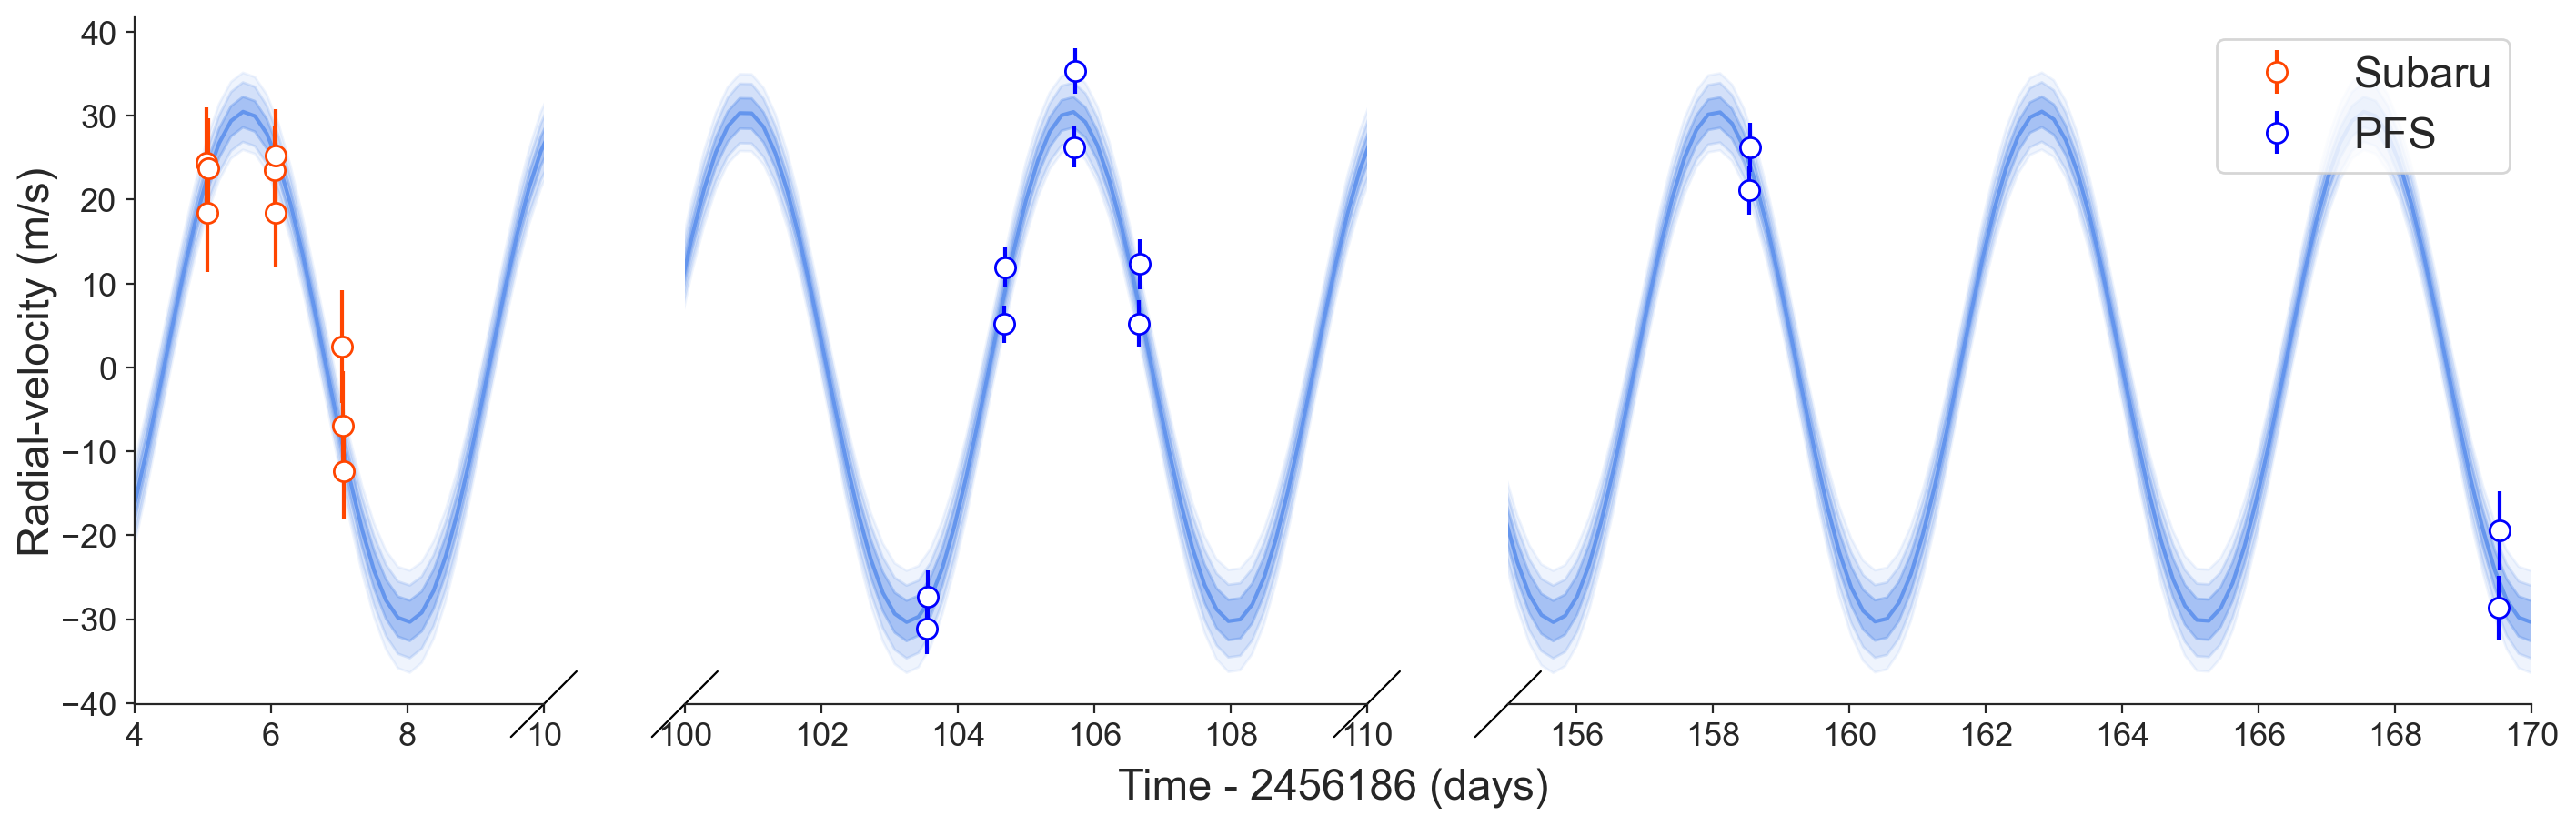

In [145]:
fig = plt.figure(figsize=(17,5))
bax = brokenaxes(xlims=((4, 10.), (100, 110), (155, 170)), hspace=.05)

for instrument,datapoint_color in [['Subaru','orangered'], ['PFS','blue']]:

    t, rv, rverr = dataset.times_rv[instrument],\
                   dataset.data_rv[instrument], \
                   dataset.errors_rv[instrument]
            
    bax.errorbar(t-tstart,rv - np.median(results.posteriors['posterior_samples']['mu_'+instrument]),rverr,fmt='o', ms=8, mec=datapoint_color,\
                 ecolor=datapoint_color,mfc='white', zorder=3, label = instrument)

bax.plot(tmodel-tstart,model, color = 'cornflowerblue',zorder=2)
bax.fill_between(tmodel-tstart, error68_down, error68_up, color = 'cornflowerblue', alpha = 0.4,zorder=1)
bax.fill_between(tmodel-tstart, error95_down, error95_up, color = 'cornflowerblue', alpha = 0.2,zorder=1)
bax.fill_between(tmodel-tstart, error99_down, error99_up, color = 'cornflowerblue', alpha = 0.1,zorder=1)
#bax.xlim(0, tend-tstart)
bax.tick_params('x', labelsize=13)
bax.tick_params('y', labelsize=13)
bax.set_xlabel('Time - '+str(tstart)+' (days)', fontsize = 17, labelpad = 25)
bax.set_ylabel('Radial-velocity (m/s)', fontsize = 17)
bax.legend(fontsize=17)
#plt.tight_layout()
plt.savefig('rvs.pdf')
#plt.ylim(-31,-1.5)

## Let's plot the GROND photometry

The GROND photometry has GPs, so it's interesting in its own right. Let's plot the g-band measurement of night 2. Let's first get the data:

In [9]:
instrument ='GROND-g-2'

In [10]:
t,f,ferr = dataset.times_lc[instrument], dataset.data_lc[instrument], dataset.errors_lc[instrument],

In [11]:
tmodel = np.linspace(np.min(t)-0.01,np.max(t)+0.01,1000)

In [12]:
model, error68_up, error68_down = results.lc.evaluate(instrument, t = tmodel, \
                                                      GPregressors =tmodel, return_err = True)

model, error95_up, error95_down = results.lc.evaluate(instrument, t = tmodel, \
                                                      GPregressors =tmodel, return_err = True, alpha = 0.95)

model, error99_up, error99_down = results.lc.evaluate(instrument, t = tmodel, \
                                                      GPregressors =tmodel, return_err = True, alpha = 0.99)



In [13]:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \
        np.median(results.posteriors['posterior_samples']['t0_p1'])

tphases = juliet.utils.get_phases(t, P, t0) * P * 24
tmodelphases = juliet.utils.get_phases(tmodel, P, t0) * P * 24

All right, let's plot this:

Text(0.5, 1.0, 'GROND-g-2')

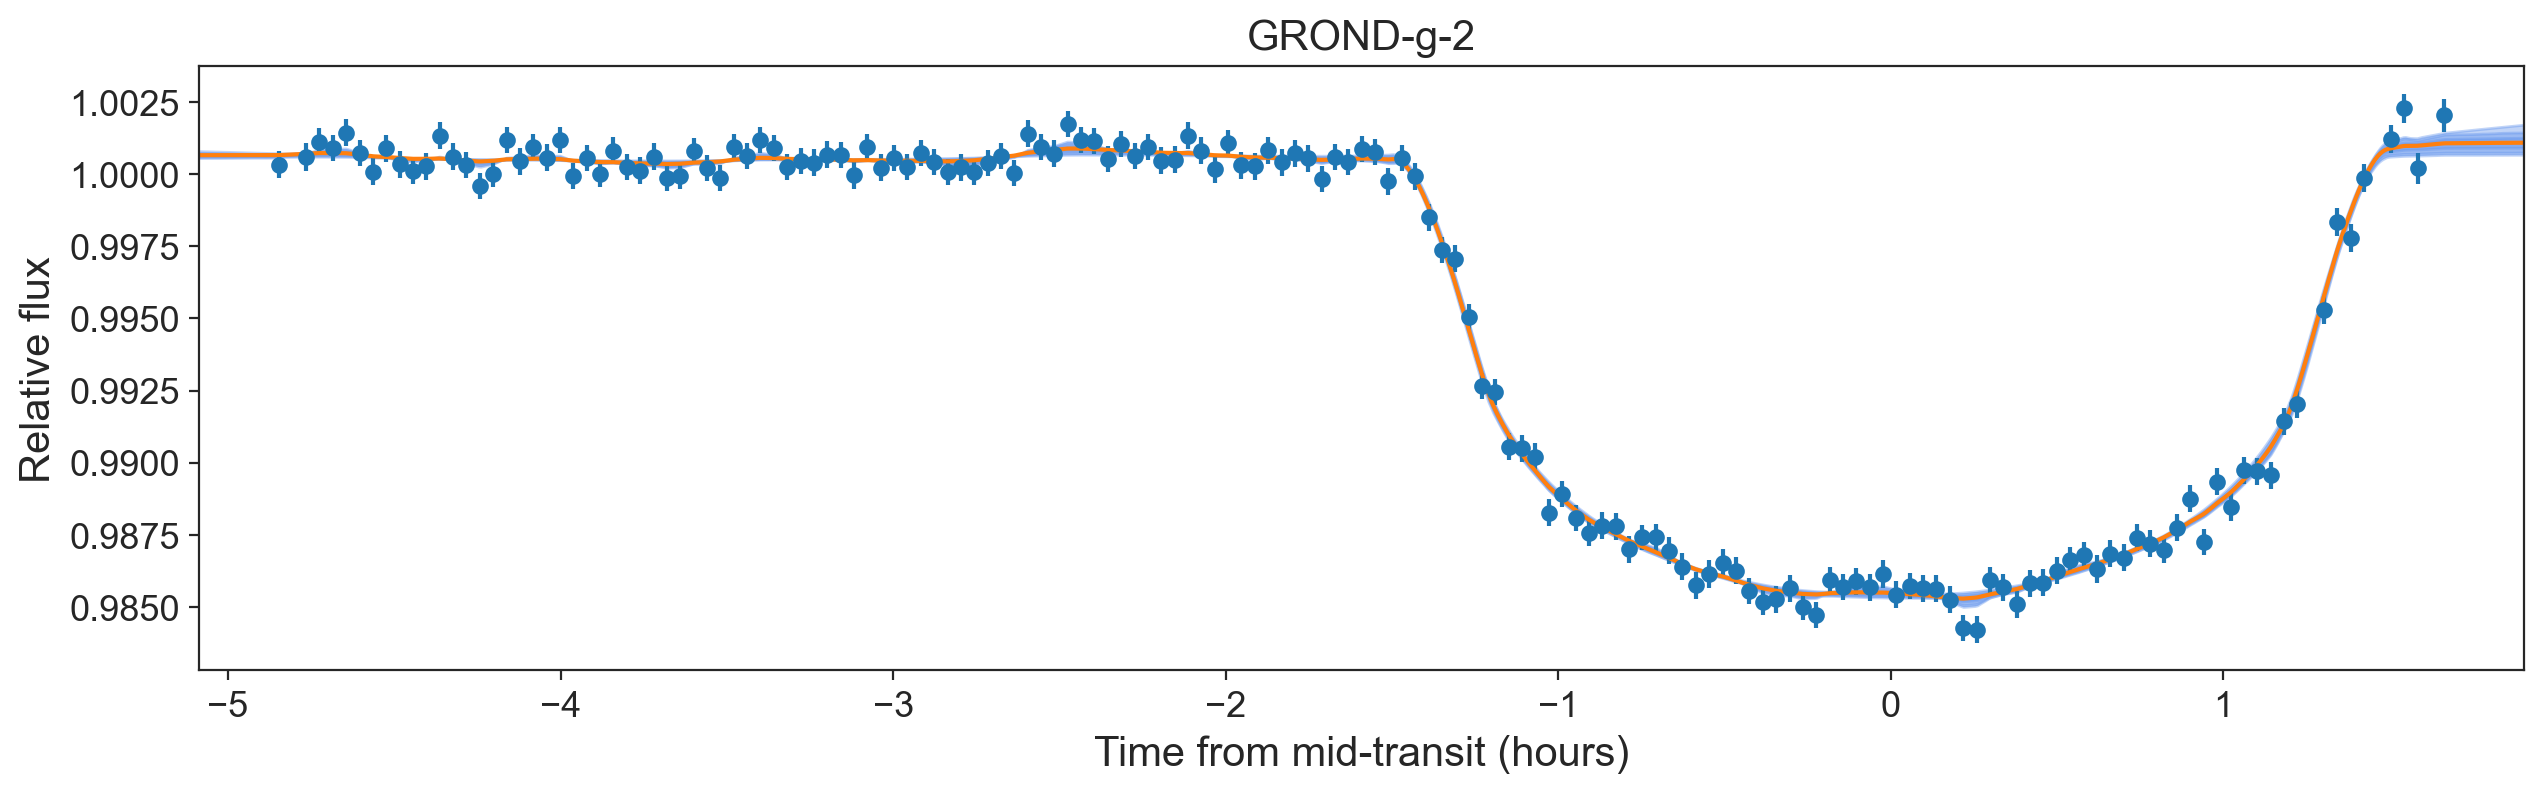

In [14]:
plt.figure(figsize=(15,4))
# Extra sigma for this dataset:
sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])

plt.errorbar(tphases, f, np.sqrt(ferr**2 + (sigma_w*1e-6)**2), fmt = 'o')
plt.plot(tmodelphases, model)
plt.fill_between(tmodelphases, error68_down, error68_up, color = 'cornflowerblue', alpha = 0.4,zorder=1)
plt.fill_between(tmodelphases, error95_down, error95_up, color = 'cornflowerblue', alpha = 0.4,zorder=1)
plt.fill_between(tmodelphases, error99_down, error99_up, color = 'cornflowerblue', alpha = 0.4,zorder=1)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Time from mid-transit (hours)', fontsize = 15)
plt.ylabel('Relative flux', fontsize = 15)
plt.xlim(np.min(tmodelphases), np.max(tmodelphases))
plt.title(instrument, fontsize = 15)

In [18]:
results.posteriors['posterior_samples'].keys()

dict_keys(['unnamed', 'loglike', 'P_p1', 't0_p1', 'p_p1', 'b_p1', 'K_p1', 'rho', 'q1_TESS5_TESS32', 'q2_TESS5_TESS32', 'GP_sigma_TESS5', 'GP_timescale_TESS5', 'GP_rho_TESS5', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS32', 'GP_timescale_TESS32', 'GP_rho_TESS32', 'mflux_TESS32', 'sigma_w_TESS32', 'q1_HS-r', 'q2_HS-r', 'mflux_HS-r', 'sigma_w_HS-r', 'q1_GROND-g-1_GROND-g-2', 'q2_GROND-g-1_GROND-g-2', 'mflux_GROND-g-1', 'mflux_GROND-g-2', 'sigma_w_GROND-g-1', 'sigma_w_GROND-g-2', 'GP_sigma_GROND-g-1', 'GP_timescale_GROND-g-1', 'GP_rho_GROND-g-1', 'GP_sigma_GROND-g-2', 'GP_timescale_GROND-g-2', 'GP_rho_GROND-g-2', 'q1_GROND-r-1_GROND-r-2', 'q2_GROND-r-1_GROND-r-2', 'mflux_GROND-r-1', 'mflux_GROND-r-2', 'sigma_w_GROND-r-1', 'sigma_w_GROND-r-2', 'GP_sigma_GROND-r-1', 'GP_timescale_GROND-r-1', 'GP_rho_GROND-r-1', 'GP_sigma_GROND-r-2', 'GP_timescale_GROND-r-2', 'GP_rho_GROND-r-2', 'q1_GROND-i-1_GROND-i-2', 'q2_GROND-i-1_GROND-i-2', 'mflux_GROND-i-1', 'mflux_GROND-i-2', 'sigma_w_GROND-i-1', '

Publication quality plots -- first, GROND on first night:

In [21]:
from matplotlib.gridspec import GridSpec

In [19]:
period, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \
             np.median(results.posteriors['posterior_samples']['t0_p1'])

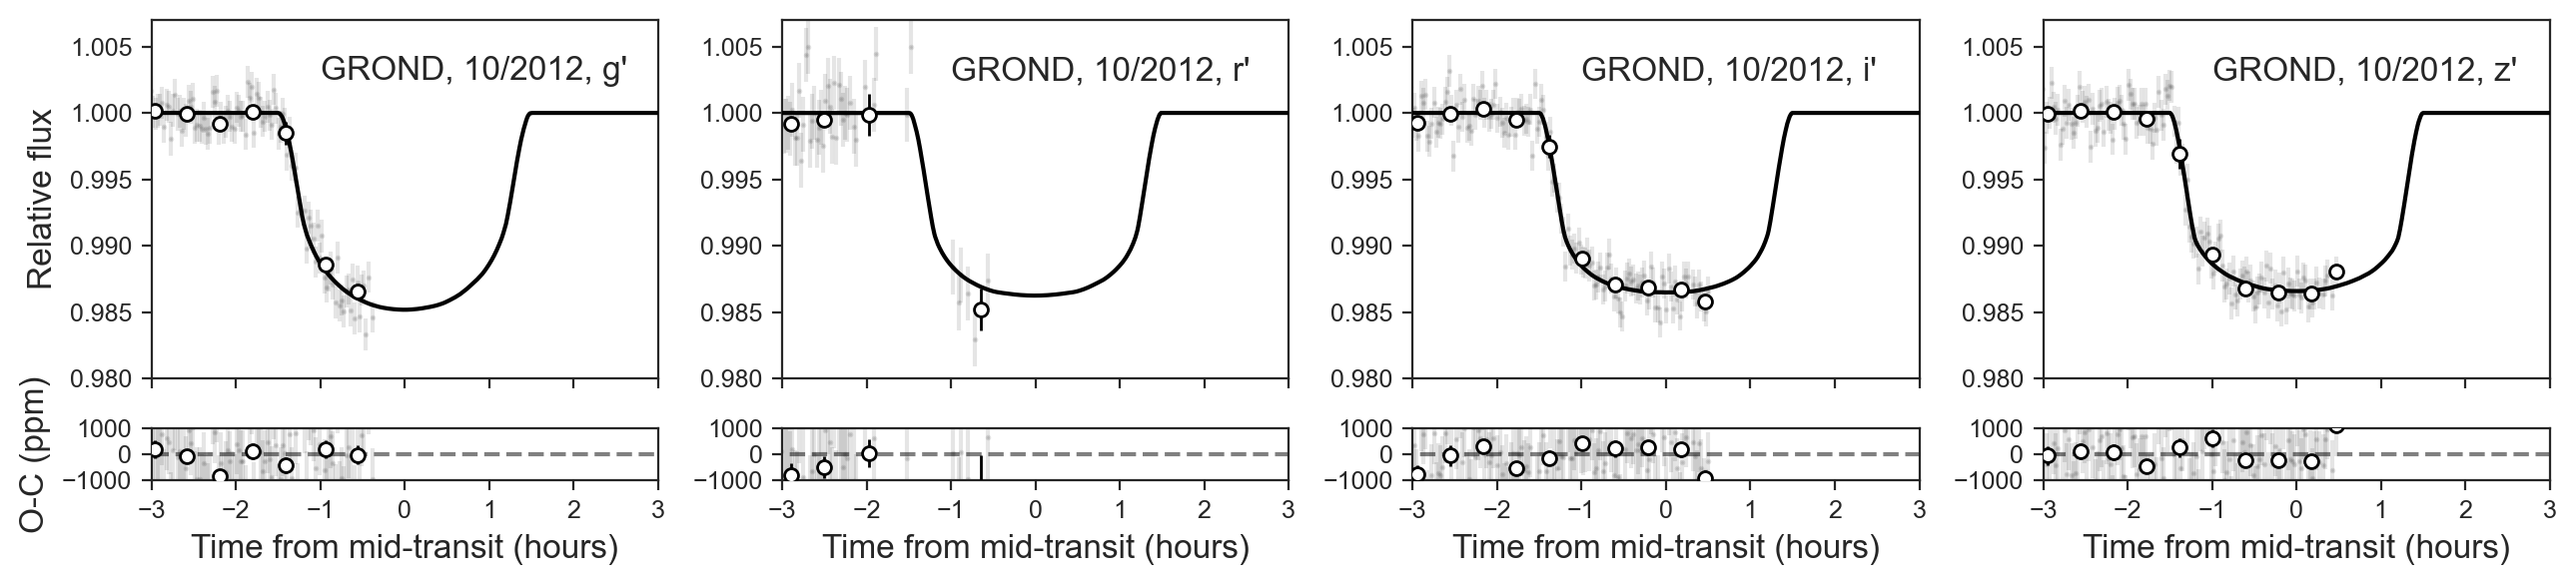

In [118]:
fig = plt.figure(figsize=(13,3))

# Divide figure using gridspec:
gs = GridSpec(5,4, figure = fig)

    
counter = 0
for sector in ['GROND-g-1', 'GROND-r-1', 'GROND-i-1', 'GROND-z-1']:
    ax = fig.add_subplot(gs[0:4, counter])
    ax_residuals = fig.add_subplot(gs[4:, counter])
    
    # Extract lightcurve data:
    t, lc, lcerr = dataset.times_lc[sector], \
                   dataset.data_lc[sector], \
                   dataset.errors_lc[sector]
    
    # Extract jitters; add them to the errors:
    sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+sector])
    lcerr = np.sqrt(lcerr**2 + (sigma_w*1e-6)**2)
    
    # Phases:
    phases = juliet.utils.get_phases(t, period, t0) * period * 24.
    
    # Evaluate model:
    model, upper, lower, components = results.lc.evaluate(sector, return_components = True, return_err = True)
    model, upper95, lower95, components = results.lc.evaluate(sector, return_components = True, return_err = True, \
                                                              alpha = 0.95)
 
    gp = model - components['transit']
    transit_upper = upper - gp
    transit_lower = lower - gp
    transit_upper95 = upper95 - gp
    transit_lower95 = lower95 - gp
    
    # Evaluate the transit model only on the entire time-range:
    transit_times = np.linspace(t0 - (5./24.), t0 + (5./24.), 1000)
    transit_model = results.lc.evaluate(sector, t = transit_times, evaluate_transit=True)
    
    transit_model = transit_model / np.max(transit_model)
    transit_phases = juliet.utils.get_phases(transit_times, period, t0) * period * 24.
    transit_idx = np.argsort(transit_phases)
    
    nbins = 15
    # Plot detrended data:
    idx = np.argsort(phases)
    ax.errorbar(phases, lc - gp, lcerr, fmt = '.', color = 'black', alpha = 0.1, ms=2, rasterized=True, zorder = 1)
    # Plot binned data:
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], lc[idx]-gp[idx], nbins)
    ax.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5)
    
    # Plot trsnsit models and errors:
    ax.plot(transit_phases[transit_idx], transit_model[transit_idx], color = 'black', zorder = 3)
    #ax.plot(phases[idx], components['transit'][idx], color = 'black', zorder = 3)
    #ax.fill_between(phases[idx], transit_lower[idx], transit_upper[idx], color = 'cornflowerblue', \
    #                zorder = 2, alpha = 0.5)
    #ax.fill_between(phases[idx], transit_lower95[idx], transit_upper95[idx], color = 'cornflowerblue', \
    #                zorder = 2, alpha = 0.5)
    
    
    # Residuals:
    ax_residuals.errorbar(phases, (lc-model)*1e6, lcerr*1e6, fmt = '.', color = 'black', alpha = 0.1, ms=2, rasterized=True)
    
    ax_residuals.plot([-5,5], [0., 0.], '--', color = 'grey', zorder = 1)
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], (lc[idx]-model[idx])*1e6, nbins)
    ax_residuals.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5)
    
    # Details for top plots:
    ax.set_xlim(-3,3)
    ax.set_ylim(0.98,1.007)
    ax.set_xticklabels([])
    band = sector.split('-')[1]
    
    if counter == 0:
        
        ax.set_ylabel('Relative flux', fontsize = 12)
        ax_residuals.set_ylabel('O-C (ppm)', fontsize = 12)
        

    ax.text(-1, 1.0025, "GROND, 10/2012, "+band+"'", fontsize = 12)
    # Details for bottom plots:
    ax_residuals.set_xlim(-3,3)
    ax_residuals.set_ylim(-1000, 1000)
    ax_residuals.set_xlabel('Time from mid-transit (hours)', fontsize = 12)
    counter += 1

plt.tight_layout()
plt.savefig('grond1_phased.pdf')

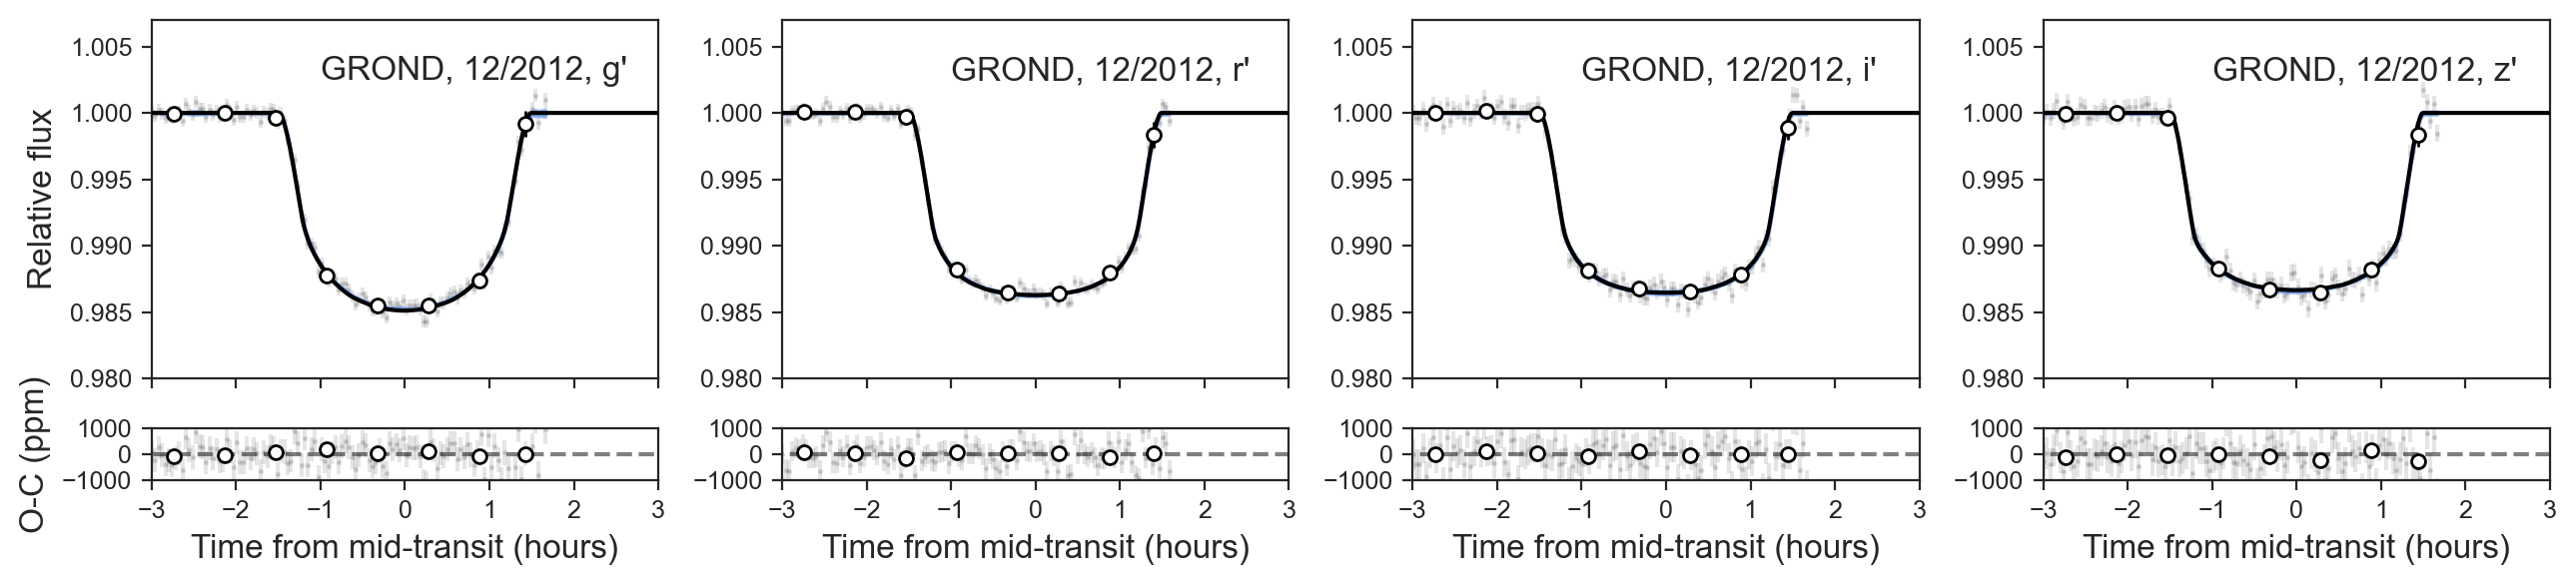

In [117]:
fig = plt.figure(figsize=(13,3))

# Divide figure using gridspec:
gs = GridSpec(5,4, figure = fig)

    
counter = 0
for sector in ['GROND-g-2', 'GROND-r-2', 'GROND-i-2', 'GROND-z-2']:
    ax = fig.add_subplot(gs[0:4, counter])
    ax_residuals = fig.add_subplot(gs[4:, counter])
    
    # Extract lightcurve data:
    t, lc, lcerr = dataset.times_lc[sector], \
                   dataset.data_lc[sector], \
                   dataset.errors_lc[sector]
    
    # Extract jitters; add them to the errors:
    sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+sector])
    lcerr = np.sqrt(lcerr**2 + (sigma_w*1e-6)**2)
    
    # Phases:
    phases = juliet.utils.get_phases(t, period, t0) * period * 24.
    
    # Evaluate model:
    model, upper, lower, components = results.lc.evaluate(sector, return_components = True, return_err = True)
    model, upper95, lower95, components = results.lc.evaluate(sector, return_components = True, return_err = True, \
                                                              alpha = 0.95)
    gp = model - components['transit']
    transit_upper = upper - gp
    transit_lower = lower - gp
    transit_upper95 = upper95 - gp
    transit_lower95 = lower95 - gp
    
    # Evaluate the transit model only on the entire time-range:
    transit_times = np.linspace(t0 - (5./24.), t0 + (5./24.), 1000)
    transit_model = results.lc.evaluate(sector, t = transit_times, evaluate_transit=True)
    
    transit_model = transit_model / np.max(transit_model)
    transit_phases = juliet.utils.get_phases(transit_times, period, t0) * period * 24.
    transit_idx = np.argsort(transit_phases)
    
    nbins = 15
    # Plot detrended data:
    idx = np.argsort(phases)
    ax.errorbar(phases, lc - gp, lcerr, fmt = '.', color = 'black', alpha = 0.1, ms=2, rasterized=True, zorder = 1)
    # Plot binned data:
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], lc[idx]-gp[idx], nbins)
    ax.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5)
    
    # Plot trsnsit models and errors:
    ax.plot(transit_phases[transit_idx], transit_model[transit_idx], color = 'black', zorder = 3)
    #ax.plot(phases[idx], components['transit'][idx], color = 'black', zorder = 3)
    ax.fill_between(phases[idx], transit_lower[idx], transit_upper[idx], color = 'cornflowerblue', \
                    zorder = 2, alpha = 0.5)
    ax.fill_between(phases[idx], transit_lower95[idx], transit_upper95[idx], color = 'cornflowerblue', \
                    zorder = 2, alpha = 0.5)
    
    
    # Residuals:
    ax_residuals.errorbar(phases, (lc-model)*1e6, lcerr*1e6, fmt = '.', color = 'black', alpha = 0.1, ms=2, rasterized=True)
    
    ax_residuals.plot([-5,5], [0., 0.], '--', color = 'grey', zorder = 1)
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], (lc[idx]-model[idx])*1e6, nbins)
    ax_residuals.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5)
    
    # Details for top plots:
    ax.set_xlim(-3,3)
    ax.set_ylim(0.98,1.007)
    ax.set_xticklabels([])
    band = sector.split('-')[1]
    
    if counter == 0:
        
        ax.set_ylabel('Relative flux', fontsize = 12)
        ax_residuals.set_ylabel('O-C (ppm)', fontsize = 12)
        

    ax.text(-1, 1.0025, "GROND, 12/2012, "+band+"'", fontsize = 12)
    # Details for bottom plots:
    ax_residuals.set_xlim(-3,3)
    ax_residuals.set_ylim(-1000, 1000)
    ax_residuals.set_xlabel('Time from mid-transit (hours)', fontsize = 12)
    counter += 1

plt.tight_layout()
plt.savefig('grond2_phased.pdf')

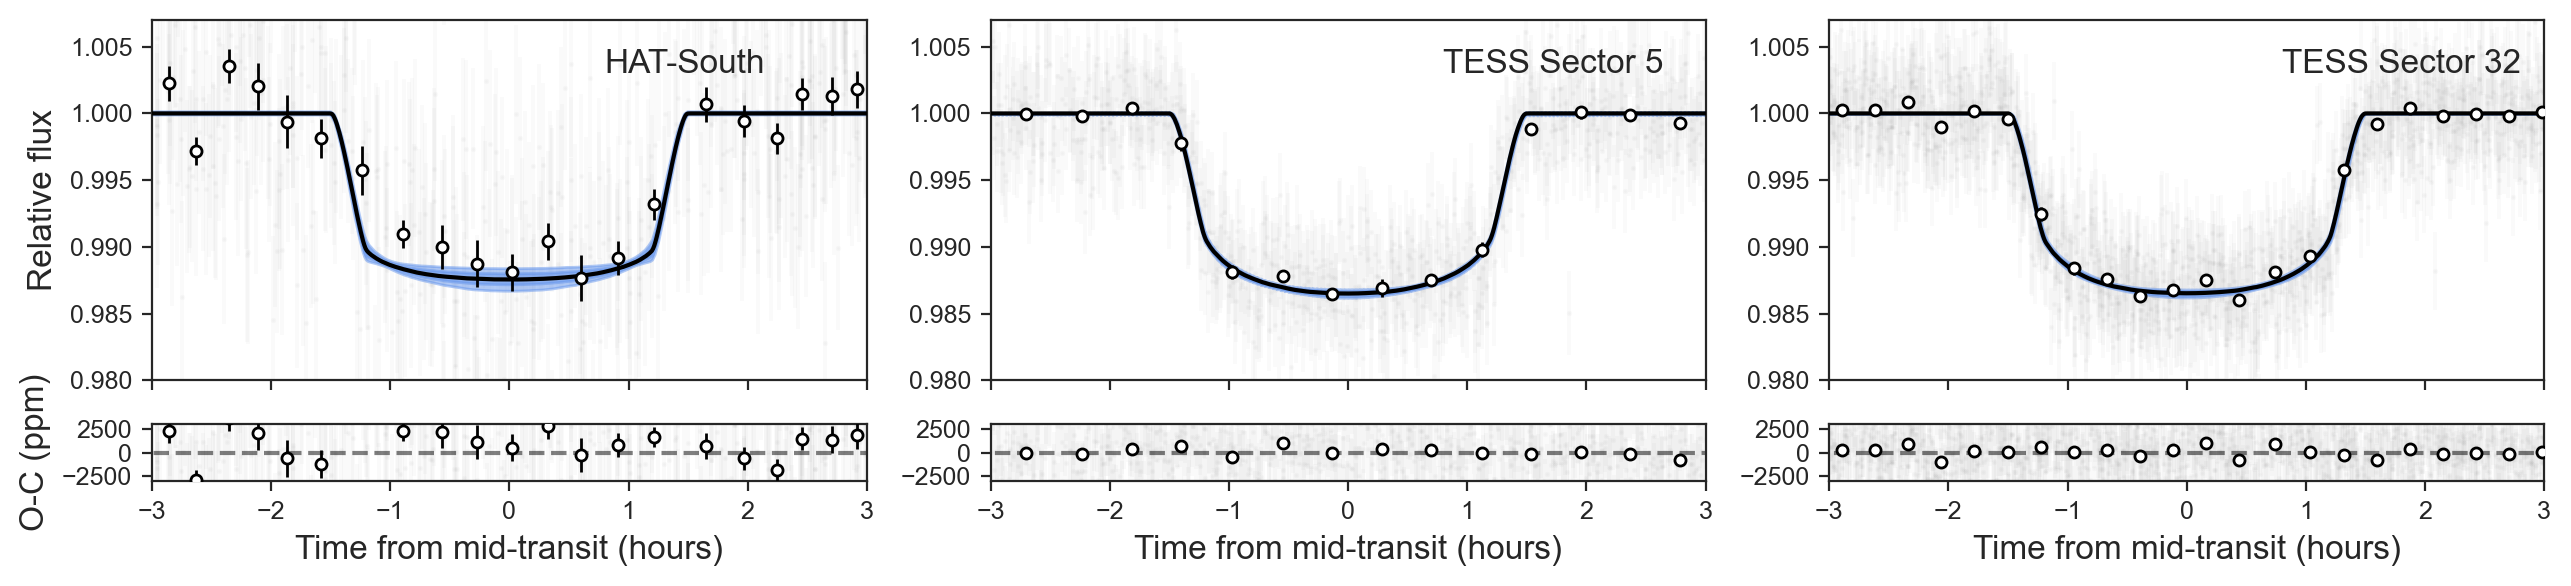

In [119]:
fig = plt.figure(figsize=(13,3))

# Divide figure using gridspec:
gs = GridSpec(5,3, figure = fig)

    
counter = 0
for sector in ['HS-r', 'TESS5', 'TESS32']:
    ax = fig.add_subplot(gs[0:4, counter])
    ax_residuals = fig.add_subplot(gs[4:, counter])
    
    # Extract lightcurve data:
    t, lc, lcerr = dataset.times_lc[sector], \
                   dataset.data_lc[sector], \
                   dataset.errors_lc[sector]
    
    # Extract jitters; add them to the errors:
    sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+sector])
    lcerr = np.sqrt(lcerr**2 + (sigma_w*1e-6)**2)
    
    # Phases:
    phases = juliet.utils.get_phases(t, period, t0) * period * 24.
    
    # Evaluate model:
    model, upper, lower, components = results.lc.evaluate(sector, return_components = True, return_err = True)
    model, upper95, lower95, components = results.lc.evaluate(sector, return_components = True, return_err = True, \
                                                              alpha = 0.95)
    gp = model - components['transit']
    transit_upper = upper - gp
    transit_lower = lower - gp
    transit_upper95 = upper95 - gp
    transit_lower95 = lower95 - gp
    
    # Evaluate the transit model only on the entire time-range:
    transit_times = np.linspace(t0 - (5./24.), t0 + (5./24.), 1000)
    transit_model = results.lc.evaluate(sector, t = transit_times, evaluate_transit=True)
    
    transit_model = transit_model / np.max(transit_model)
    transit_phases = juliet.utils.get_phases(transit_times, period, t0) * period * 24.
    transit_idx = np.argsort(transit_phases)
    
    if sector == 'HS-r':
        nbins = 21
    else:
        nbins = 50
    # Plot detrended data:
    idx = np.argsort(phases)
    ax.errorbar(phases, lc - gp, lcerr, fmt = '.', color = 'black', alpha = 0.02, ms=2, rasterized=True, zorder = 1)
    # Plot binned data:
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], lc[idx]-gp[idx], nbins)
    ax.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5, ms =4)
    
    # Plot trsnsit models and errors:
    ax.plot(transit_phases[transit_idx], transit_model[transit_idx], color = 'black', zorder = 3)
    #ax.plot(phases[idx], components['transit'][idx], color = 'black', zorder = 3)
    ax.fill_between(phases[idx], transit_lower[idx], transit_upper[idx], color = 'cornflowerblue', \
                    zorder = 2, alpha = 0.5)
    ax.fill_between(phases[idx], transit_lower95[idx], transit_upper95[idx], color = 'cornflowerblue', \
                    zorder = 2, alpha = 0.5)
    
    
    # Residuals:
    ax_residuals.errorbar(phases, (lc-model)*1e6, lcerr*1e6, fmt = '.', color = 'black', alpha = 0.02, ms=2, rasterized=True)
    
    ax_residuals.plot([-5,5], [0., 0.], '--', color = 'grey', zorder = 1)
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], (lc[idx]-model[idx])*1e6, nbins)
    ax_residuals.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5, ms = 4)
    
    # Details for top plots:
    ax.set_xlim(-3,3)
    ax.set_ylim(0.98,1.007)
    ax.set_xticklabels([])
    
    if counter == 0:
        
        ax.set_ylabel('Relative flux', fontsize = 12)
        ax_residuals.set_ylabel('O-C (ppm)', fontsize = 12)
        
    if sector != 'HS-r':
        ax.text(0.8, 1.003, "TESS Sector "+sector.split('TESS')[-1], fontsize = 12)
        # Details for bottom plots:
        ax_residuals.set_xlim(-3,3)
        ax_residuals.set_ylim(-3000,3000)
    else:
        ax.text(0.8, 1.003, "HAT-South", fontsize = 12)
        # Details for bottom plots:
        ax_residuals.set_xlim(-3,3)
        ax_residuals.set_ylim(-3000,3000)
    ax_residuals.set_xlabel('Time from mid-transit (hours)', fontsize = 12)
    counter += 1
    
plt.tight_layout()
plt.savefig('tess_phased.pdf')

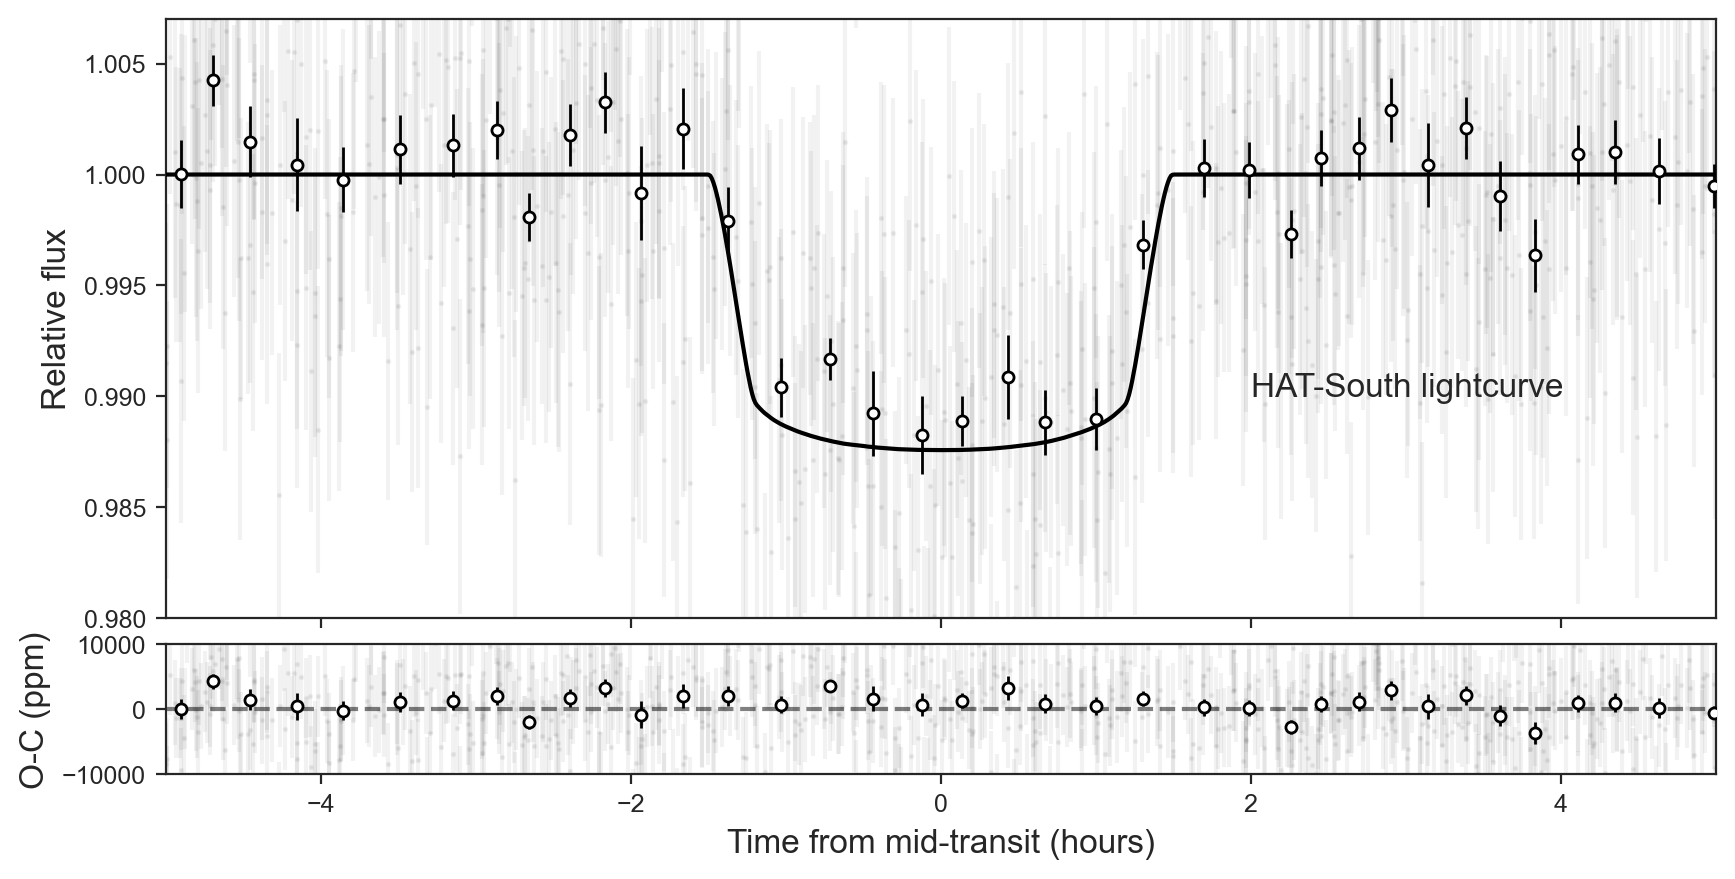

In [84]:
fig = plt.figure(figsize=(10,5))

# Divide figure using gridspec:
gs = GridSpec(5,1, figure = fig)

    
counter = 0
for sector in ['HS-r']:
    ax = fig.add_subplot(gs[0:4, counter])
    ax_residuals = fig.add_subplot(gs[4:, counter])
    
    # Extract lightcurve data:
    t, lc, lcerr = dataset.times_lc[sector], \
                   dataset.data_lc[sector], \
                   dataset.errors_lc[sector]
    
    # Extract jitters; add them to the errors:
    sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+sector])
    lcerr = np.sqrt(lcerr**2 + (sigma_w*1e-6)**2)
    
    # Phases:
    phases = juliet.utils.get_phases(t, period, t0) * period * 24.
    
    # Evaluate model:
    model, upper, lower, components = results.lc.evaluate(sector, return_components = True, return_err = True)
    model, upper95, lower95, components = results.lc.evaluate(sector, return_components = True, return_err = True, \
                                                              alpha = 0.95)
    gp = model - components['transit']
    transit_upper = upper - gp
    transit_lower = lower - gp
    transit_upper95 = upper95 - gp
    transit_lower95 = lower95 - gp
    
    # Evaluate the transit model only on the entire time-range:
    transit_times = np.linspace(t0 - (5./24.), t0 + (5./24.), 1000)
    transit_model = results.lc.evaluate(sector, t = transit_times, evaluate_transit=True)
    
    transit_model = transit_model / np.max(transit_model)
    transit_phases = juliet.utils.get_phases(transit_times, period, t0) * period * 24.
    transit_idx = np.argsort(transit_phases)
    
    nbins = 20
    # Plot detrended data:
    idx = np.argsort(phases)
    ax.errorbar(phases, lc - gp, lcerr, fmt = '.', color = 'black', alpha = 0.05, ms=2, rasterized=True, zorder = 1)
    # Plot binned data:
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], lc[idx]-gp[idx], nbins)
    ax.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5, ms =4)
    
    # Plot trsnsit models and errors:
    ax.plot(transit_phases[transit_idx], transit_model[transit_idx], color = 'black', zorder = 3)
    #ax.plot(phases[idx], components['transit'][idx], color = 'black', zorder = 3)
    #ax.fill_between(phases[idx], transit_lower[idx], transit_upper[idx], color = 'cornflowerblue', \
    #                zorder = 2, alpha = 0.5)
    #ax.fill_between(phases[idx], transit_lower95[idx], transit_upper95[idx], color = 'cornflowerblue', \
    #                zorder = 2, alpha = 0.5)
    
    
    # Residuals:
    ax_residuals.errorbar(phases, (lc-model)*1e6, lcerr*1e6, fmt = '.', color = 'black', alpha = 0.05, ms=2, rasterized=True)
    
    ax_residuals.plot([-5,5], [0., 0.], '--', color = 'grey', zorder = 1)
    xbin, ybin, ybinerr = juliet.utils.bin_data(phases[idx], (lc[idx]-model[idx])*1e6, nbins)
    ax_residuals.errorbar(xbin, ybin, ybinerr, fmt = 'o', mec = 'black', ecolor = 'black', mfc = 'white', \
                elinewidth=1, rasterized=True, zorder = 5, ms = 4)
    
    # Details for top plots:
    ax.set_xlim(-5,5)
    ax.set_ylim(0.98,1.007)
    ax.set_xticklabels([])
    
    if counter == 0:
        
        ax.set_ylabel('Relative flux', fontsize = 12)
        ax_residuals.set_ylabel('O-C (ppm)', fontsize = 12)
        

    ax.text(2.0, 0.99, "HAT-South lightcurve", fontsize = 12)
    # Details for bottom plots:
    ax_residuals.set_xlim(-5,5)
    ax_residuals.set_ylim(-10000,10000)
    ax_residuals.set_xlabel('Time from mid-transit (hours)', fontsize = 12)
    counter += 1
    
plt.savefig('hs_phased.pdf')

### Let's plot the TESS lightcurves



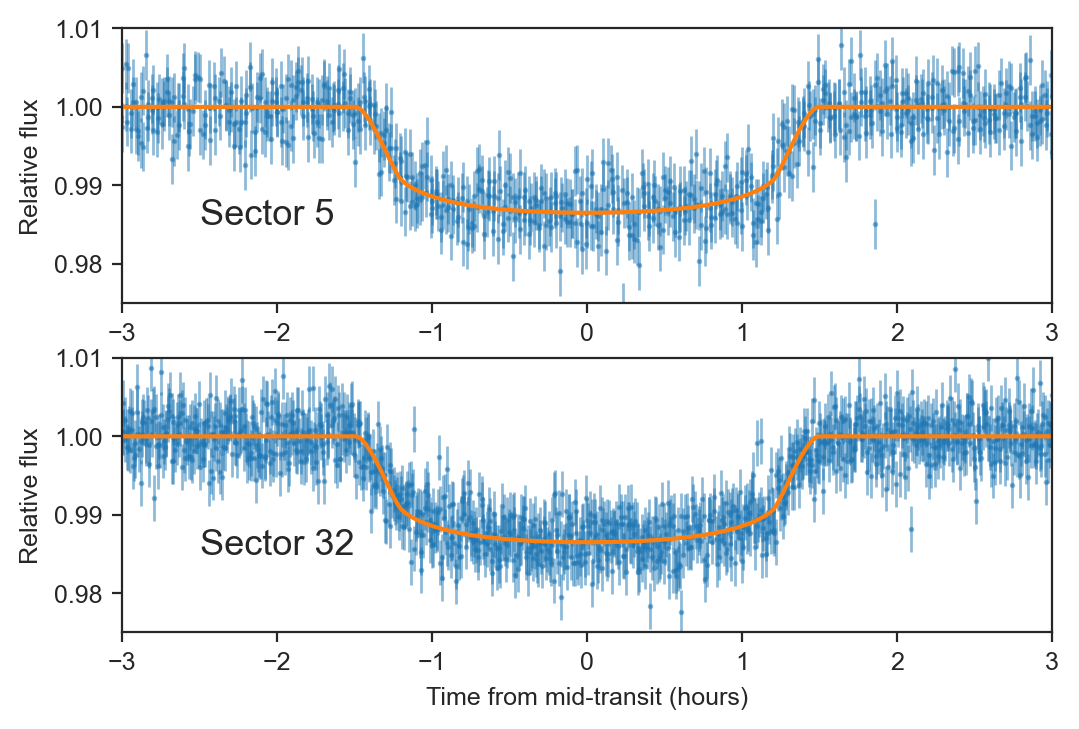

In [15]:
counter = 1
for sector in ['TESS5', 'TESS32']:
    plt.subplot('21'+str(counter))
    t,f,ferr = dataset.times_lc[sector], dataset.data_lc[sector], dataset.errors_lc[sector]
    
    model, components = results.lc.evaluate(sector, return_components = True)
    gp = model - components['transit']
    
    sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    phases = juliet.utils.get_phases(t, P, t0) * P * 24
    plt.errorbar(phases, f - gp , np.sqrt(ferr**2 + (sigma_w*1e-6)**2), fmt = '.', \
                 elinewidth=1,ms=2, zorder=1, alpha = 0.5)
    idx = np.argsort(phases)
    plt.plot(phases[idx], components['transit'][idx],zorder=2)
    counter += 1
    plt.xlim(-3,3)
    plt.ylim(0.975,1.01)
    plt.text(-2.5,0.985,'Sector '+sector.split('TESS')[-1], fontsize=13)
    plt.ylabel('Relative flux')
plt.xlabel('Time from mid-transit (hours)')
components.keys()
plt.savefig('tess.pdf')

In [146]:
p = results.posteriors['posterior_samples']['p_p1']
depth = (p**2)*1e6

In [147]:
np.median(depth), np.sqrt(np.var(depth))

(11279.534166231291, 115.02124045219688)

In [148]:
rho = results.posteriors['posterior_samples']['rho']
b = results.posteriors['posterior_samples']['b_p1']

In [153]:
G = 6.67408e-11
posteriors = results.posteriors
planet = 'p1'

In [154]:
a = ((posteriors['posterior_samples']['rho']*G*((posteriors['posterior_samples']['P_'+planet]*24.*3600.)**2))/(3.*np.pi))**(1./3.)

In [155]:
juliet.utils.get_quantiles(a)

(13.381271569815636, 13.479926301929162, 13.249354433963385)

In [156]:
13.479926301929162-13.381271569815636

0.09865473211352516

In [157]:
13.381271569815636-13.249354433963385

0.13191713585225173

In [ ]:
13.381^{+0.098}_{-0.0132}

In [158]:
inc = np.arccos(b/a) * (180./np.pi)

In [159]:
juliet.utils.get_quantiles(inc)

(89.38688571233583, 89.65996670509833, 89.11459180976851)

In [160]:
89.65996670509833-89.38688571233583

0.27308099276250175

In [161]:
89.11459180976851-89.38688571233583

-0.2722939025673128

In [ ]:
89.39 \pm 0.27